# Explaining RL Decisions with Trajectories

This file contains code used for generating results of the gridworld experiments.

In [45]:
# Regular data science libraries
import numpy as np
import pandas as pd
import json
import os
import pickle
import random


# DNN libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# Import utility functions from other files
from utils import generate_model, dp, generate_offline_data
from env import Agent, Environment


# Plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('ieee')


# Clustering libraries
from sklearn.decomposition import PCA
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from scipy.stats import wasserstein_distance

# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)


### Instantiate the Environment

Pick one of the three provided environments: FourRooms, 7x7 (default), or 5x5. The environment implementation is provided in a script attached with this notebook.

In [2]:
# # Four Rooms Environment

# action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
# reward_dict = {1:0, -1:1, -0.1:2, 0:3}

# #####

# # Environment Definition
# env_width = 11
# env_height = 11
# env = Environment(dim=(env_width, env_height),
# #                   starts=[(2, 0), (6, 2), (2,4), (5,5)],
#                   terminals={(0, 0): +1, (0, 10): +1, (4, 3): -1, (8, 2):-1, (2, 8):+1, (3, 6):-1, (7,7):-1, (10, 6):-1, (10, 4):+1, (10, 8):+1},
#                   obstacles=[[0, 5], [1, 5], [3, 5], [4, 5], [5, 0], [5, 2], [5, 3], [5, 4], [5, 5], [6, 5], [7, 5], [8, 5], [10, 5], [6, 6], [6, 7], [6, 9], [6, 10]],
#                   stoc=0.)

# env.render(title='Four Rooms')

# # Initialize the agent
# agent = Agent(env)

# #####

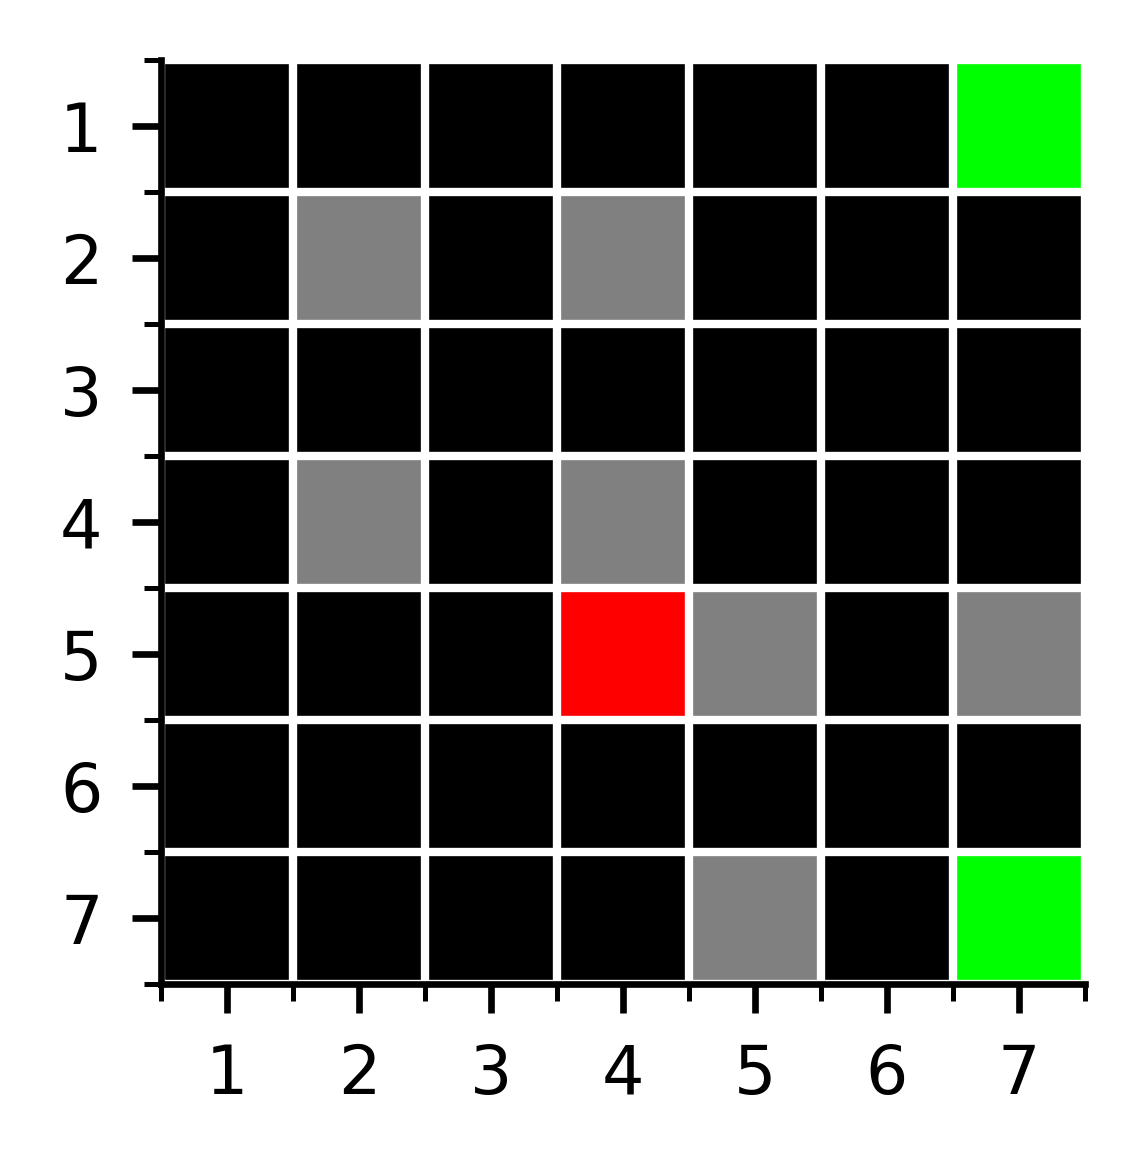

In [3]:
# # 7x7 Gridworld Environment

action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
reward_dict = {1:0, -1:1, -0.1:2, 0:3}

#####

# Environment Definition
env_width = 7
env_height = 7
env = Environment(dim=(env_width, env_height),
                  starts=[(2, 0), (6, 2), (2,4)],
                  terminals={(0, 6): +1, (6, 6): +1, (4, 3): -1},
                  obstacles=[[1, 1], [1, 3], [3, 1], [3, 3], [4,4], [6, 4], [4,6]],
                  stoc=0.)

env.render(title='7x7 Gridworld')

# Initialize the agent
agent = Agent(env)

#####

In [4]:
# # 5x5 Gridworld Environment
# action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
# reward_dict = {1:0, -1:1, -0.1:2, 0:3}

# #####

# # Environment Definition
# env_width = 5
# env_height = 5
# env = Environment(dim=(env_width, env_height),
#                   starts=[(4, 4), (4, 2)],
#                   terminals={(0, 1): +1, (4, 4): -1},
#                   obstacles=[[3,2],[3,3]],
#                   stoc=0.)

# env.render(title='Gridworld')

# # Initialize the agent
# agent = Agent(env)

# #####

### Collecting offline trajectory data

In [5]:
# Generate offline data for the training
num_episodes_dyna = 2
num_agents_dyna = 20
max_traj_len = 20
num_pos_trajs = 500
num_neg_trajs = 100
offline_data = generate_offline_data(env, agent, num_episodes_dyna, num_agents_dyna, max_traj_len, num_pos_trajs, num_neg_trajs)

#####

Training 20 Agents


100%|██████████| 20/20 [00:00<00:00, 37.31it/s]


# POS TRAJs 1
# NEG TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# NEG TRAJs 2
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# NEG TRAJs 3
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# NEG TRAJs 4
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# NEG TRAJs 5
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# NEG TRAJs 6
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# NEG TRAJs 7
# NEG TRAJs 8
# POS TRAJs 43
# NEG TRAJs 9
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# NEG TRAJs 10
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
# POS TRAJs 51
# POS TRAJs 52
# NEG TRAJs 11
# POS TRAJs 53
# NEG TRAJs 12
# POS TRAJs 54
# POS TRAJs 55
# POS TRAJs 5

In [6]:
## If you are planning to pickle these trajectories and use them instead of generating them every time...
# results_save_dir = './gridworld_results/grid_7by7/'
# with open(os.path.join(results_save_dir, 'offline_traj.pkl'), 'wb') as f:
#     pickle.dump(offline_data, f)

# with open(os.path.join(results_save_dir, 'offline_traj.pkl'), 'rb') as f:
#     offline_data = pickle.load(f)

In [7]:
# Plot a trajectory to check if the data has been correctly formed
# env.plot_traj(offline_data[-1])

## Sequential Encoder

We use sequential encoder to parse the offline data and create clusters of the trajectories which will be used for attributing the decisions in the later steps.

In [8]:
def tokenizer(trajectories, state_space_dim, action_dict, reward_dict, max_traj_len = 25):
    """
        Tokenizer for capturing gridworld trajectories
    """

    action_space_dim = len(action_dict)
    reward_set_dim = len(reward_dict)
    
    # TOKEN IDs
    # 1 START TOKEN
    # 2 END TOKEN
    # 0 PAD TOKEN
    # STATE TOKENs
    # ACTION TOKENs
    # REWARD TOKENs
    
    complete_traj_tokens = []
    
    for traj in trajectories:
        # Traj contains (s,a,r,s')
        # We generate tokens for 's', 'a' and 'r'
        
        traj_tokens = []
        
        # Start token
        traj_tokens.append(1)
        
        for sars_ in traj:
            s = sars_[0]
            a = sars_[1]
            r = sars_[2]
            
            # State
            traj_tokens.append(3 + s)
            
            # Action
            traj_tokens.append(3 + state_space_dim + a)
            
            # Reward
            traj_tokens.append(3 + state_space_dim + action_space_dim + reward_dict[r])
        
        # Remove action and reward for terminal state, TO BE USED ONLY when (s_terminal, a_random, reward = 0, s_terminal) exists at the end of trajectory data
        traj_tokens.pop()
        traj_tokens.pop()
        
        # End token
        traj_tokens.append(2)
        
        # Pad with zero tokens
        if max_traj_len + 3 - len(traj) > 0:
            traj_tokens = traj_tokens + [0]*(3*(max_traj_len + 3 - len(traj)))
        
        complete_traj_tokens.append(torch.LongTensor(traj_tokens))
    
    return complete_traj_tokens

vocab_size = 3 + env_width*env_height + len(action_dict) + len(reward_dict)

tokenized_data = tokenizer(offline_data, 
                          state_space_dim = env_width*env_height, 
                          action_dict = action_dict, 
                          reward_dict = reward_dict, 
                          max_traj_len = max_traj_len)

## Training AE to encode trajectories

In [63]:
def compute_traveled_vectors(trajectories):
    """
    Computes the vectors traveled for a list of trajectories.

    Args:
    - trajectories: A list of trajectories, each trajectory is a list of states,
      and each state is represented by coordinates (i, j).

    Returns:
    - A list of vectors representing the movement from the start to the end of each trajectory.
      Each vector is represented as (delta_i, delta_j).
    """
    traveled_vectors = []

    for traj in trajectories:
        if not traj:  # Check if the trajectory is empty
            continue

        # Extract start and end points
        start_point = traj[0]  # First state's coordinates
        end_point = traj[-1]  # Last state's coordinates

        # Compute the traveled vector
        vector = (end_point[0] - start_point[0], end_point[1] - start_point[1])
        traveled_vectors.append(vector)

    return traveled_vectors

traveled_vectors = compute_traveled_vectors(offline_data)

traveled_vectors_tensor = torch.tensor(traveled_vectors, dtype=torch.float32)

# Create rewards tensor
rewards = torch.tensor([1] * num_pos_trajs + [-1] * num_neg_trajs, dtype=torch.float32).view(-1, 1)

# Concatenate traveled_vectors with rewards for each entry
data_with_rewards = torch.cat((traveled_vectors_tensor, rewards), dim=1)

class TrajectoryDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Return the entire data entry (including the reward) as both input and target
        return self.data[idx], self.data[idx]  # (input, target)


# Create dataset and dataloader
dataset = TrajectoryDataset(data_with_rewards)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [70]:
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(3, 2)  # Assuming the input data is flattened if necessary; reduces dimension from 3 to 2
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 3)  # Attempts to reconstruct the original 3-dimensional data from the 2D encoded form
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder model
model = SimpleAutoencoder()


In [71]:
data_with_rewards[0]

tensor([-12.,  -2.,   1.])

In [72]:
dataset[0]

(tensor([-12.,  -2.,   1.]), tensor([-12.,  -2.,   1.]))

In [73]:
# Hyperparameters 
num_epochs = 25

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [74]:
model.train()
for epoch_id in range(num_epochs):
    total_loss = 0
    for data, target in dataloader:
        optimizer.zero_grad()
        
        reconstructed_data = model(data)
        
        # Calculate loss
        loss = F.mse_loss(reconstructed_data, target)
        
        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        total_loss += loss.item()

    # Print average loss
    print(f'Epoch: {epoch_id + 1}, Avg Loss: {total_loss / len(dataloader)}')

Epoch: 1, Avg Loss: 49.47866516113281
Epoch: 2, Avg Loss: 48.585021591186525
Epoch: 3, Avg Loss: 47.450551223754886
Epoch: 4, Avg Loss: 46.46788787841797
Epoch: 5, Avg Loss: 45.4727596282959
Epoch: 6, Avg Loss: 44.48219985961914
Epoch: 7, Avg Loss: 43.881496047973634
Epoch: 8, Avg Loss: 42.96903991699219
Epoch: 9, Avg Loss: 42.07821502685547
Epoch: 10, Avg Loss: 41.53513031005859
Epoch: 11, Avg Loss: 40.700561904907225
Epoch: 12, Avg Loss: 40.4706226348877
Epoch: 13, Avg Loss: 40.01441841125488
Epoch: 14, Avg Loss: 39.74696235656738
Epoch: 15, Avg Loss: 39.29728012084961
Epoch: 16, Avg Loss: 38.49281806945801
Epoch: 17, Avg Loss: 38.54358749389648
Epoch: 18, Avg Loss: 37.743500518798825
Epoch: 19, Avg Loss: 37.57579803466797
Epoch: 20, Avg Loss: 36.967641830444336
Epoch: 21, Avg Loss: 36.80029563903808
Epoch: 22, Avg Loss: 35.90464553833008
Epoch: 23, Avg Loss: 35.471092987060544
Epoch: 24, Avg Loss: 34.95183639526367
Epoch: 25, Avg Loss: 34.48193702697754


In [12]:
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_5.pth')
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_fourrooms.pth')
torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_7.pth')

## Trajectory Attribution 

Starts here...

### Encode trajectories in the offline dataset

In [75]:
# Assuming `data_with_rewards` is a tensor where the last column is the reward
# and `model` is your autoencoder model with an accessible encoder module.

# Initialize a list to hold trajectory embeddings
traj_embeddings = []

# Iterate over the data to process each trajectory
for traj in data_with_rewards:
    with torch.no_grad():
        # Exclude the reward from the input to the autoencoder
        input_data = traj.unsqueeze(0)  # Add batch dimension

        # Encode the trajectory to get its embedding
        # Here, we directly access the encoder part of the autoencoder
        embedding = model.encoder(input_data)
        
        # Convert the tensor to numpy array and reshape
        # The `embedding` tensor is already 2D (encoded), so we might not need to reshape it
        embedding_np = embedding.numpy().reshape(-1)
        
        # Append the embedding to the list
        traj_embeddings.append(embedding_np)


### PCA analysis of the trajectory embeddings

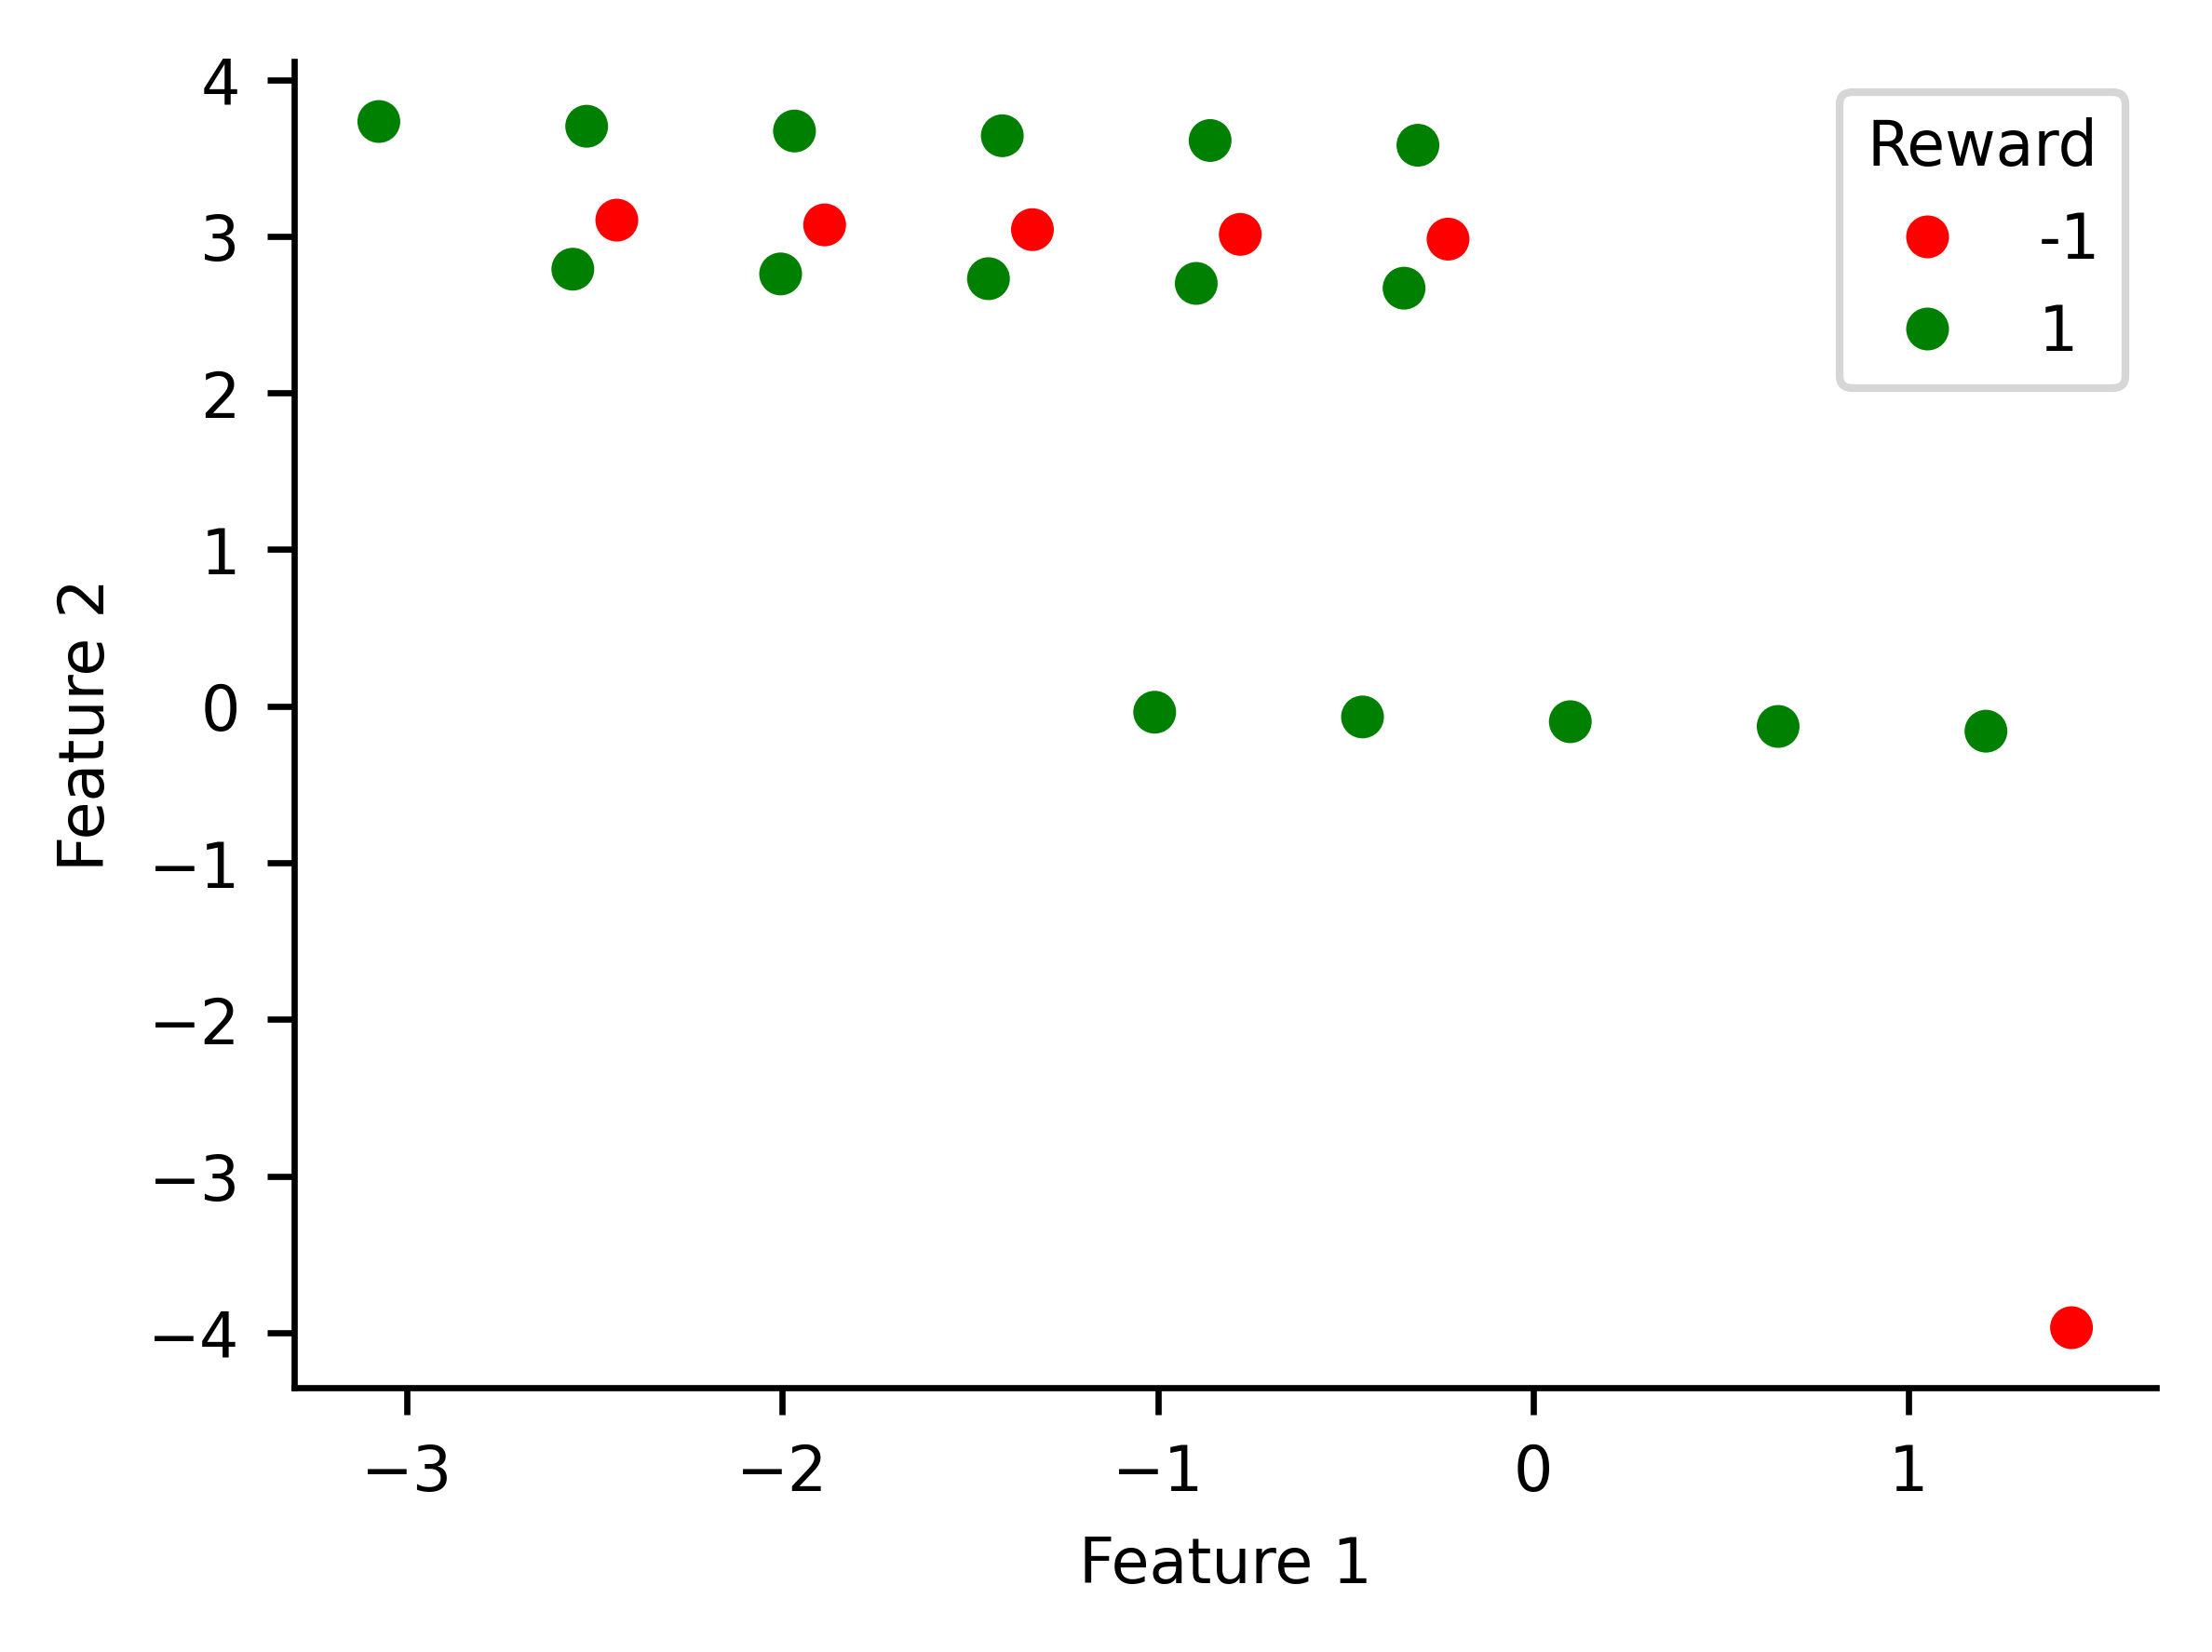

In [78]:
traj_embeddings_np = np.array(traj_embeddings)

# Prepare the rewards
rewards = [+1] * num_pos_trajs + [-1] * num_neg_trajs

# Create a DataFrame for plotting
plotting_data = {
    'feature 1': traj_embeddings_np[:, 0],
    'feature 2': traj_embeddings_np[:, 1],
    'rewards': rewards
}
df = pd.DataFrame(plotting_data)

# Plotting
plt.figure(figsize=(4, 3))
sns.scatterplot(x='feature 1', y='feature 2', hue='rewards', palette={-1: "r", 1: "g"}, data=df)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Reward', loc='best')
plt.tight_layout()
plt.show()

### Clustering of the trajectories using X-Means

In [17]:

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(traveled_vectors, amount_initial_centers).initialize()
 
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 10.
xmeans_instance = xmeans(traveled_vectors, initial_centers, 10)
xmeans_instance.process()
 
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
 
# Print total sum of metric errors
# print("Total WCE:", xmeans_instance.get_total_wce())
# print("Clusters:", clusters)
# print('Number of clusters', len(clusters))

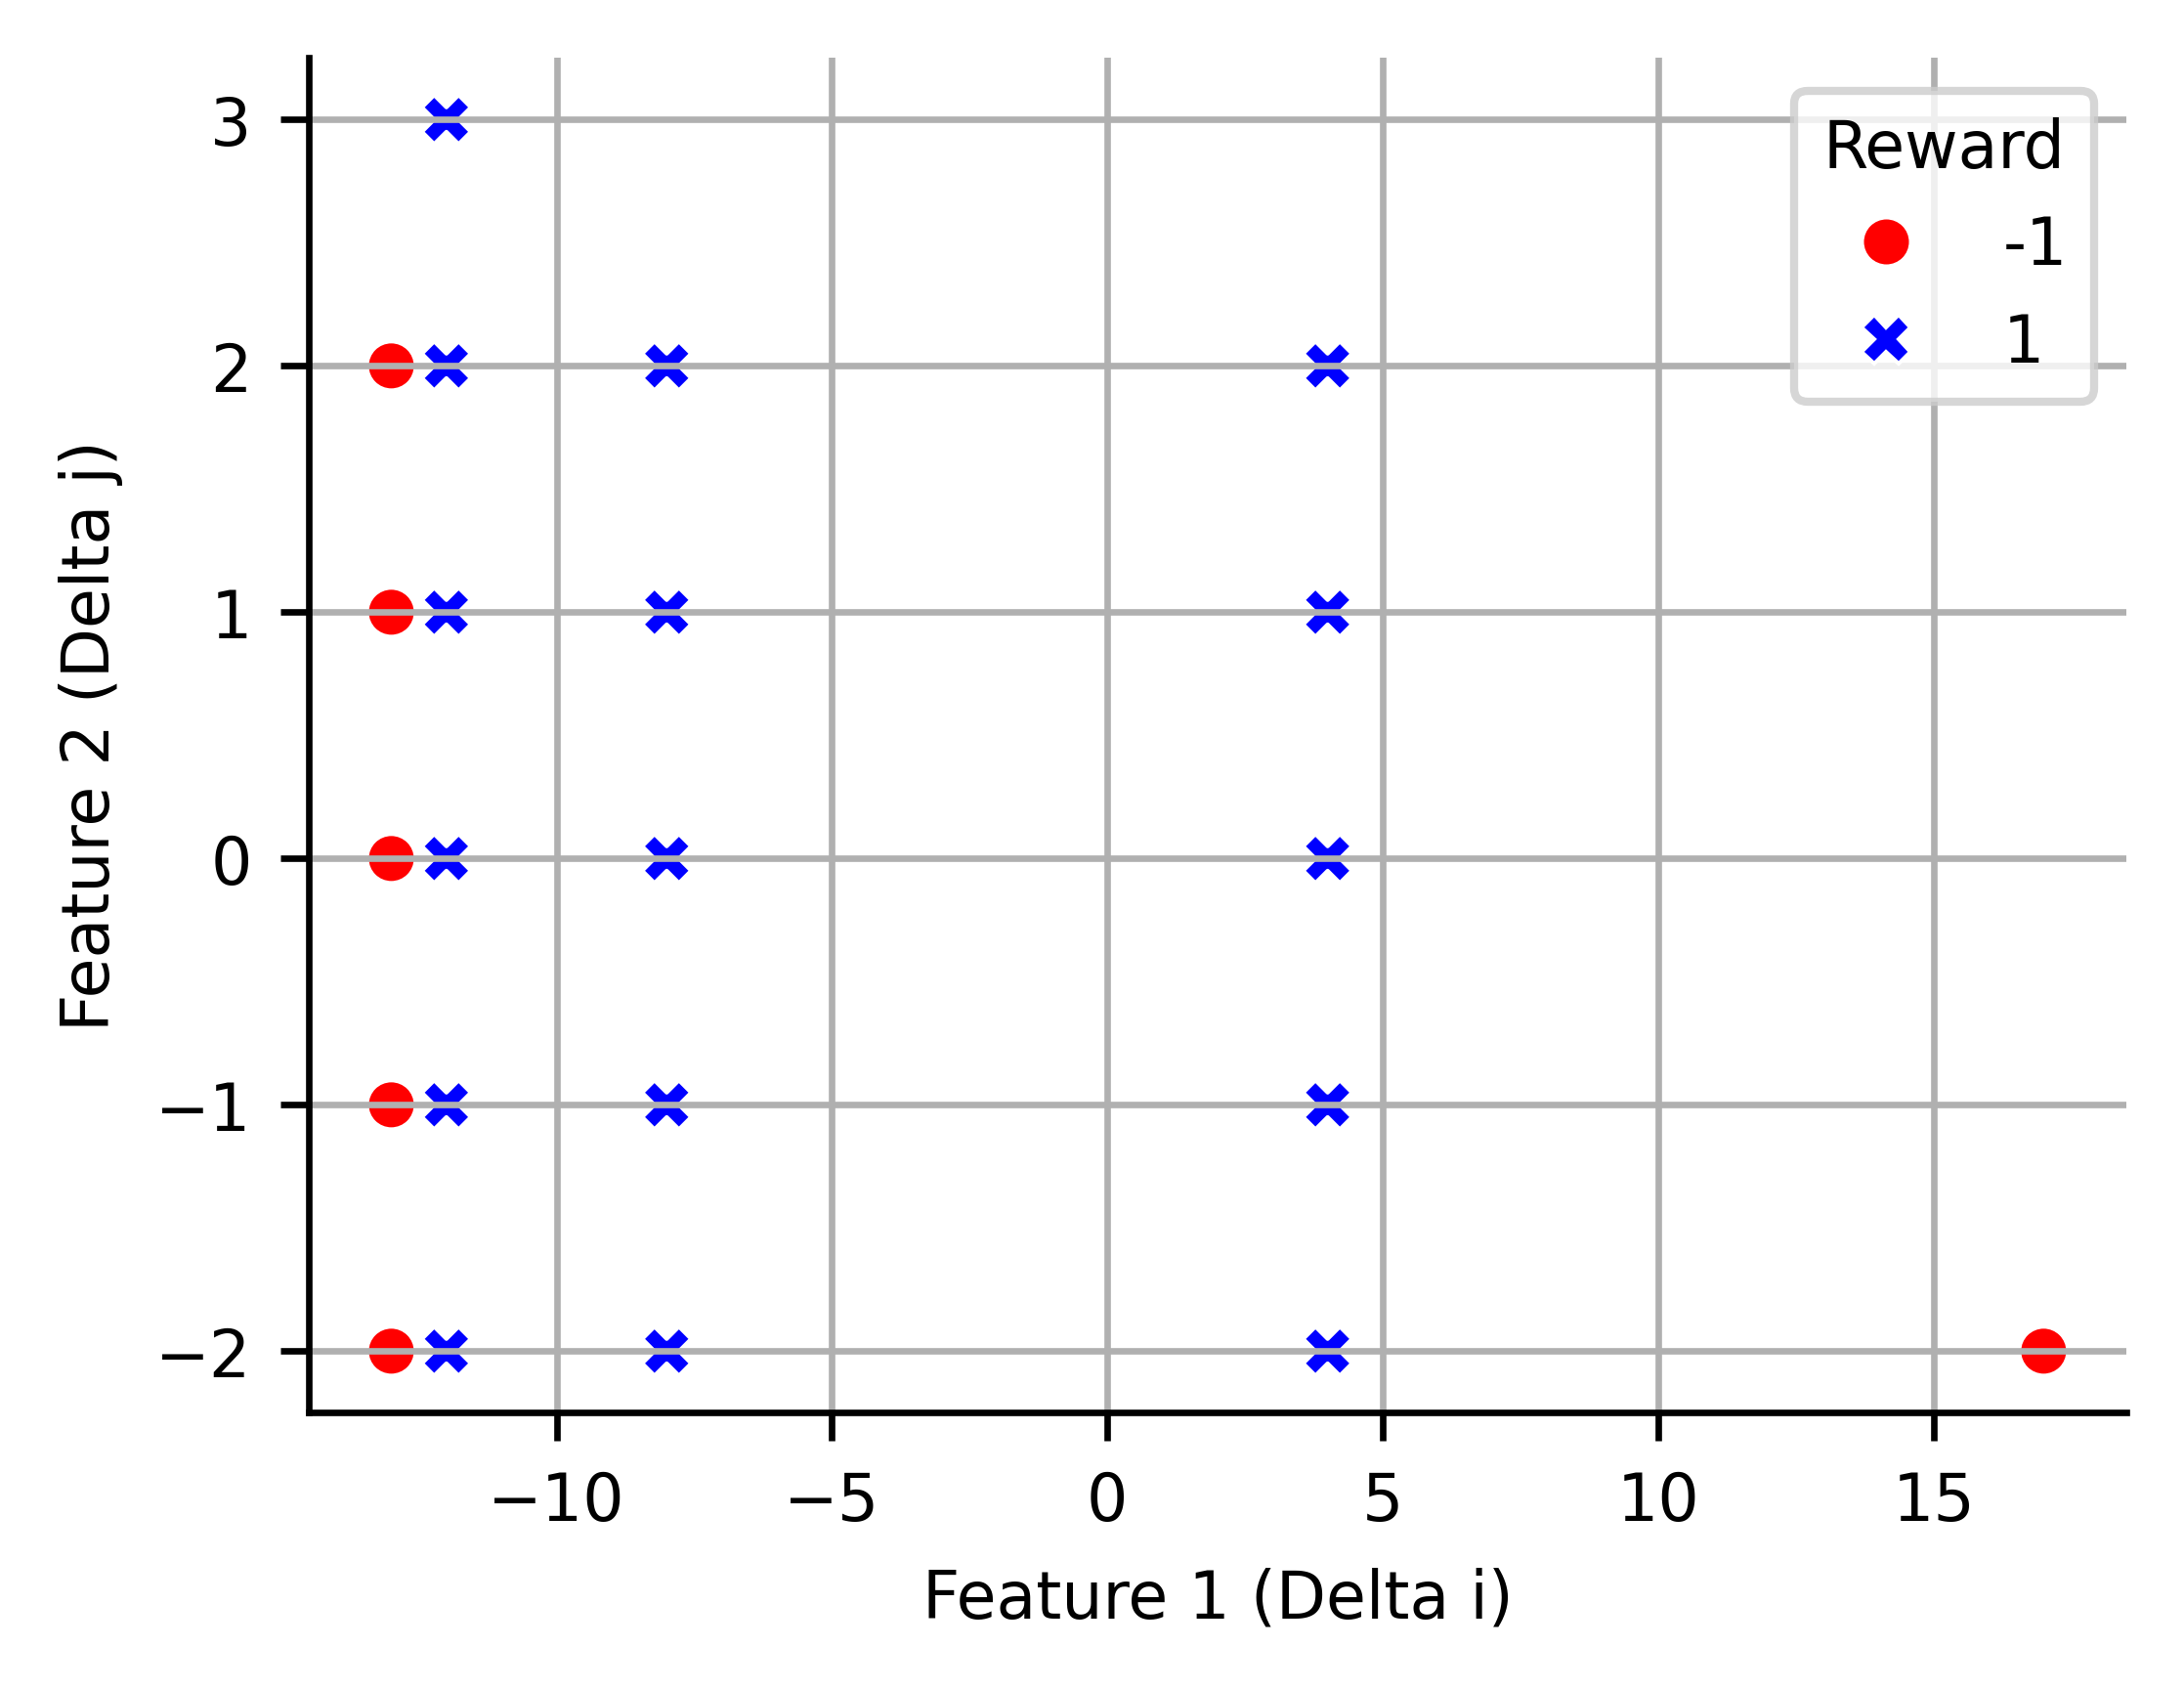

In [18]:
plotting_data = {
    'Delta i': [vec[0] for vec in traveled_vectors],
    'Delta j': [vec[1] for vec in traveled_vectors],
    'Rewards': [+1] * num_pos_trajs + [-1] * num_neg_trajs
}

df = pd.DataFrame(plotting_data)

# Plot
plt.figure(figsize=(4, 3))
sns.scatterplot(x='Delta i', y='Delta j', hue='Rewards', data=df, palette=['red', 'blue'], style='Rewards', markers=['o', 'X'])
plt.xlabel('Feature 1 (Delta i)')
plt.ylabel('Feature 2 (Delta j)')
# plt.title('Traveled Vectors with Rewards')
plt.legend(title='Reward')
plt.grid(True)  # Optional: Adds grid for better readability
plt.show()

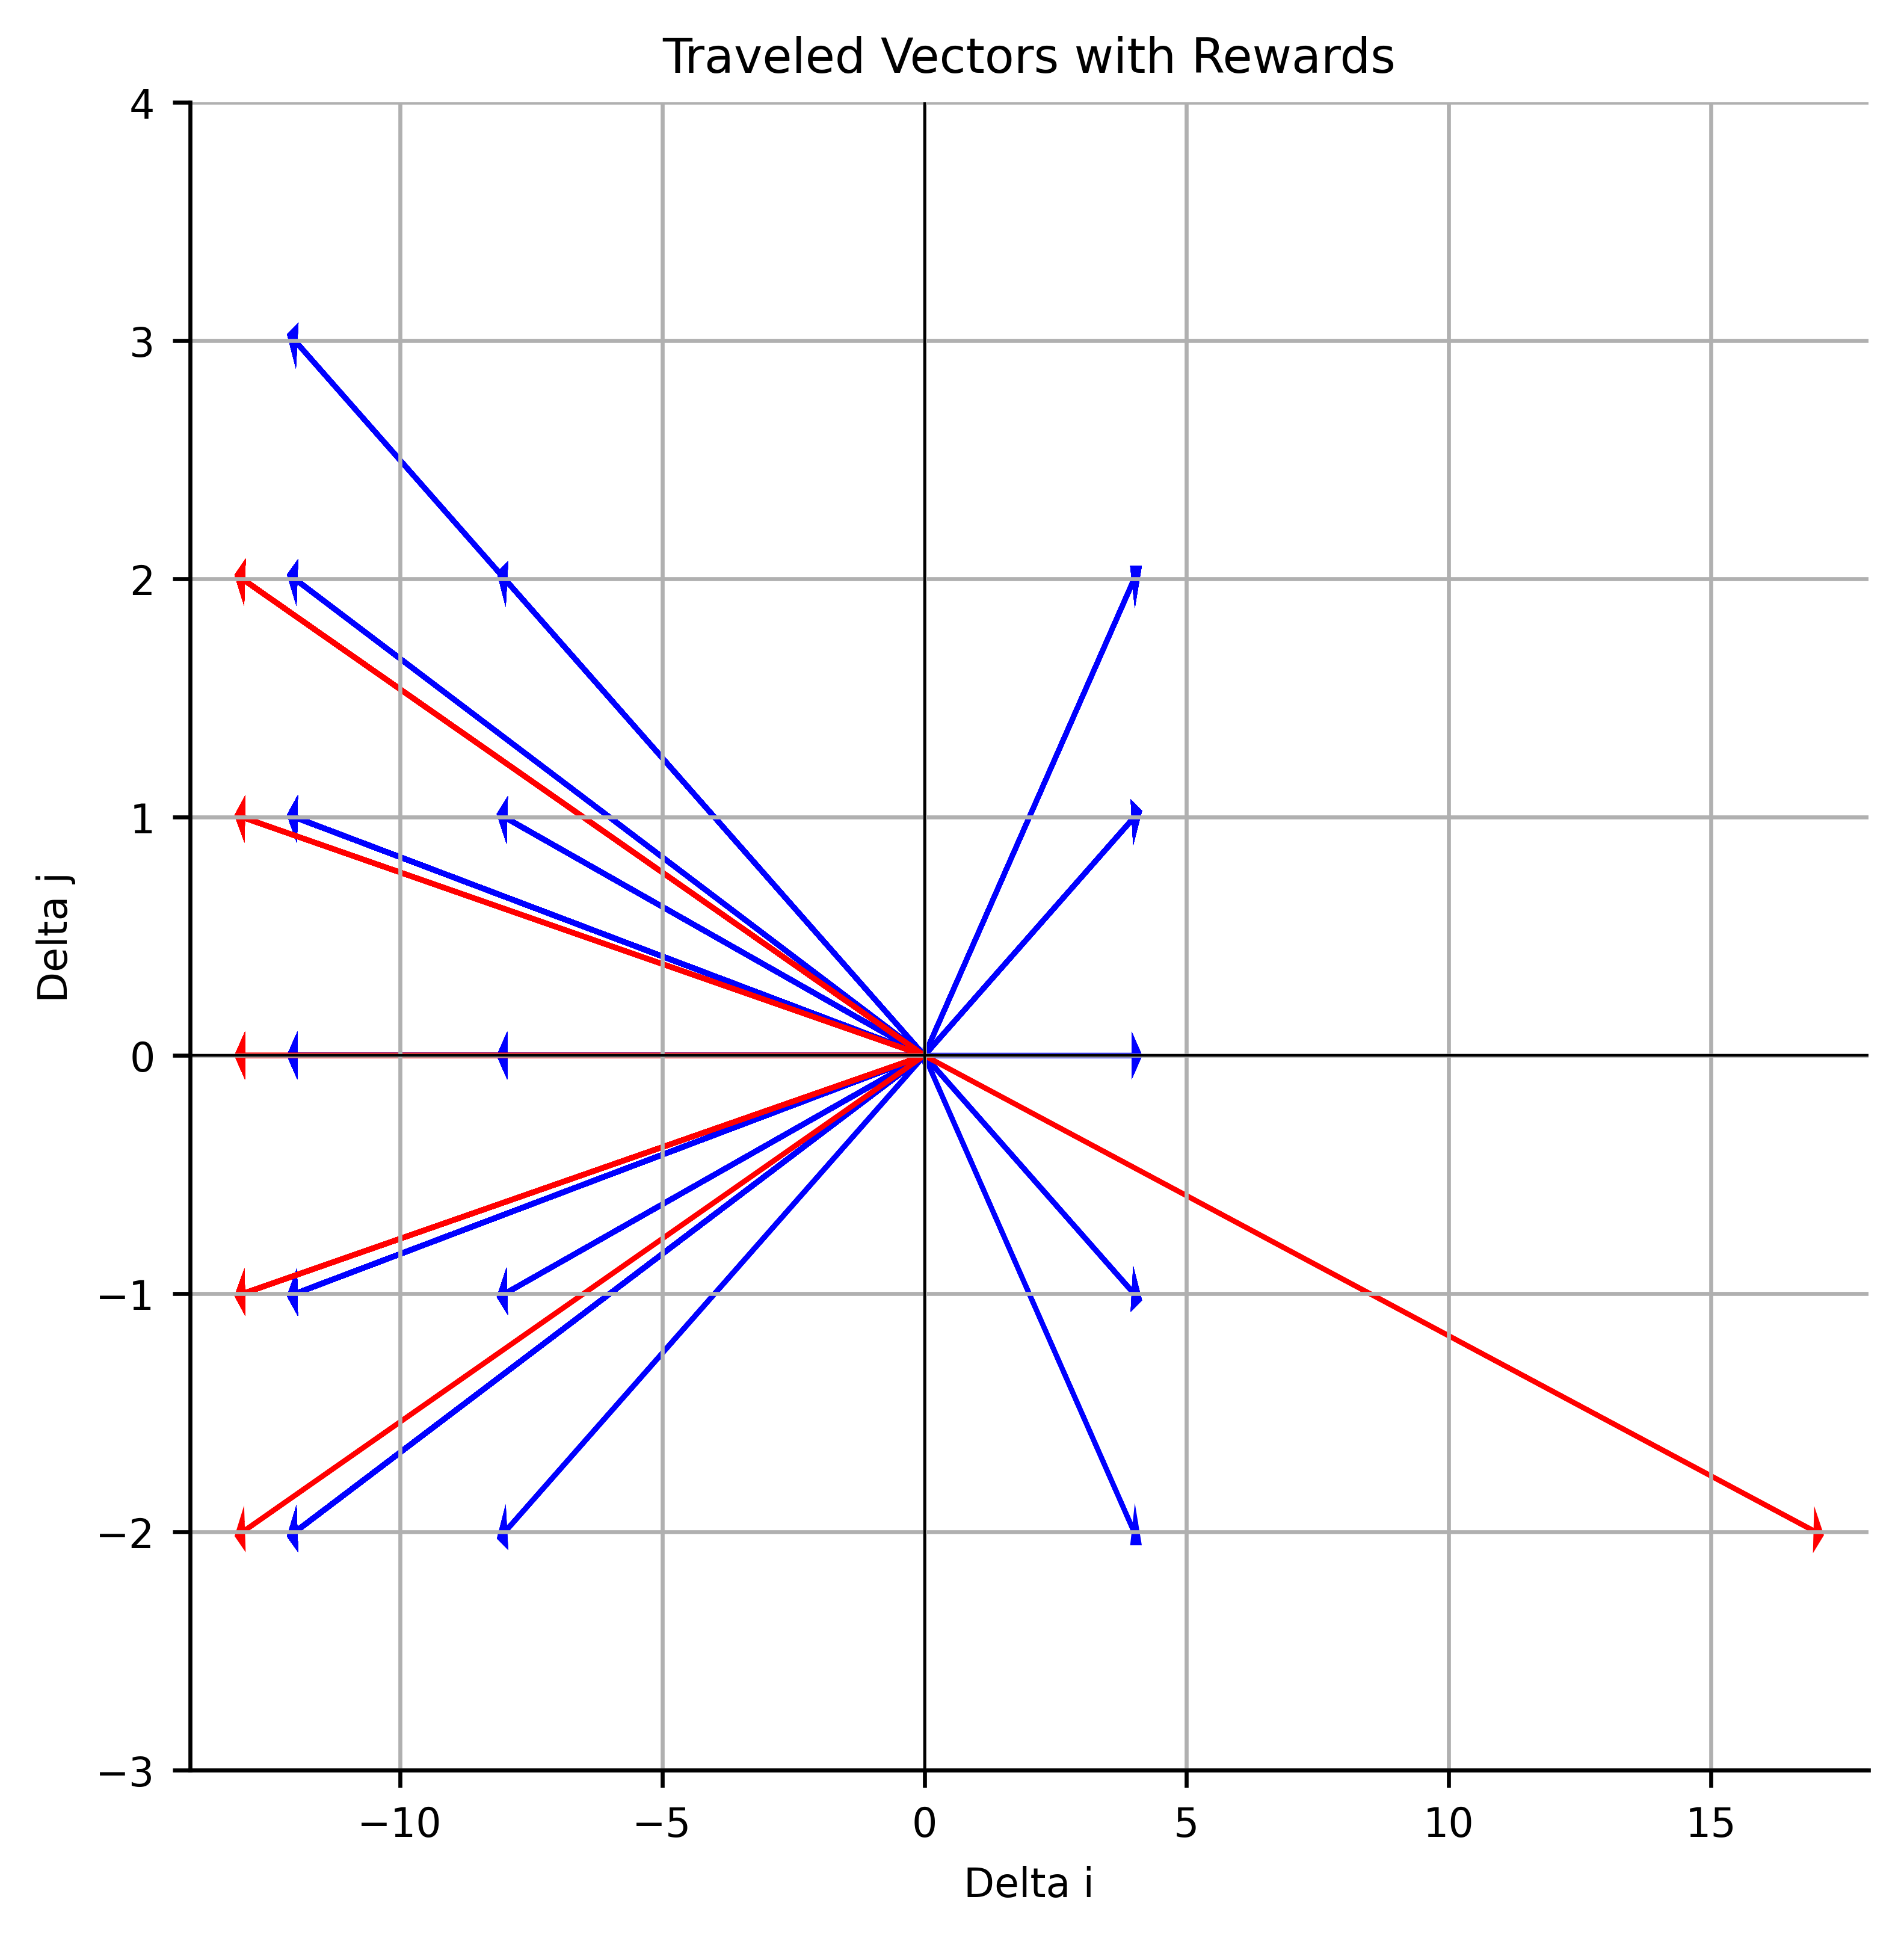

In [19]:
rewards =  [+1] * num_pos_trajs + [-1] * num_neg_trajs
plt.figure(figsize=(6, 6))
for vector, reward in zip(traveled_vectors, rewards):
    # Determine color based on reward
    color = 'blue' if reward == +1 else 'red'
    
    # Draw the vector as an arrow
    plt.arrow(0, 0, vector[0], vector[1], head_width=0.1, head_length=0.1, fc=color, ec=color)

# Setting the plot limits
plt.xlim(min([v[0] for v in traveled_vectors]) - 1, max([v[0] for v in traveled_vectors]) + 1)
plt.ylim(min([v[1] for v in traveled_vectors]) - 1, max([v[1] for v in traveled_vectors]) + 1)

plt.xlabel('Delta i')
plt.ylabel('Delta j')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(True)
plt.title('Traveled Vectors with Rewards')
plt.show()

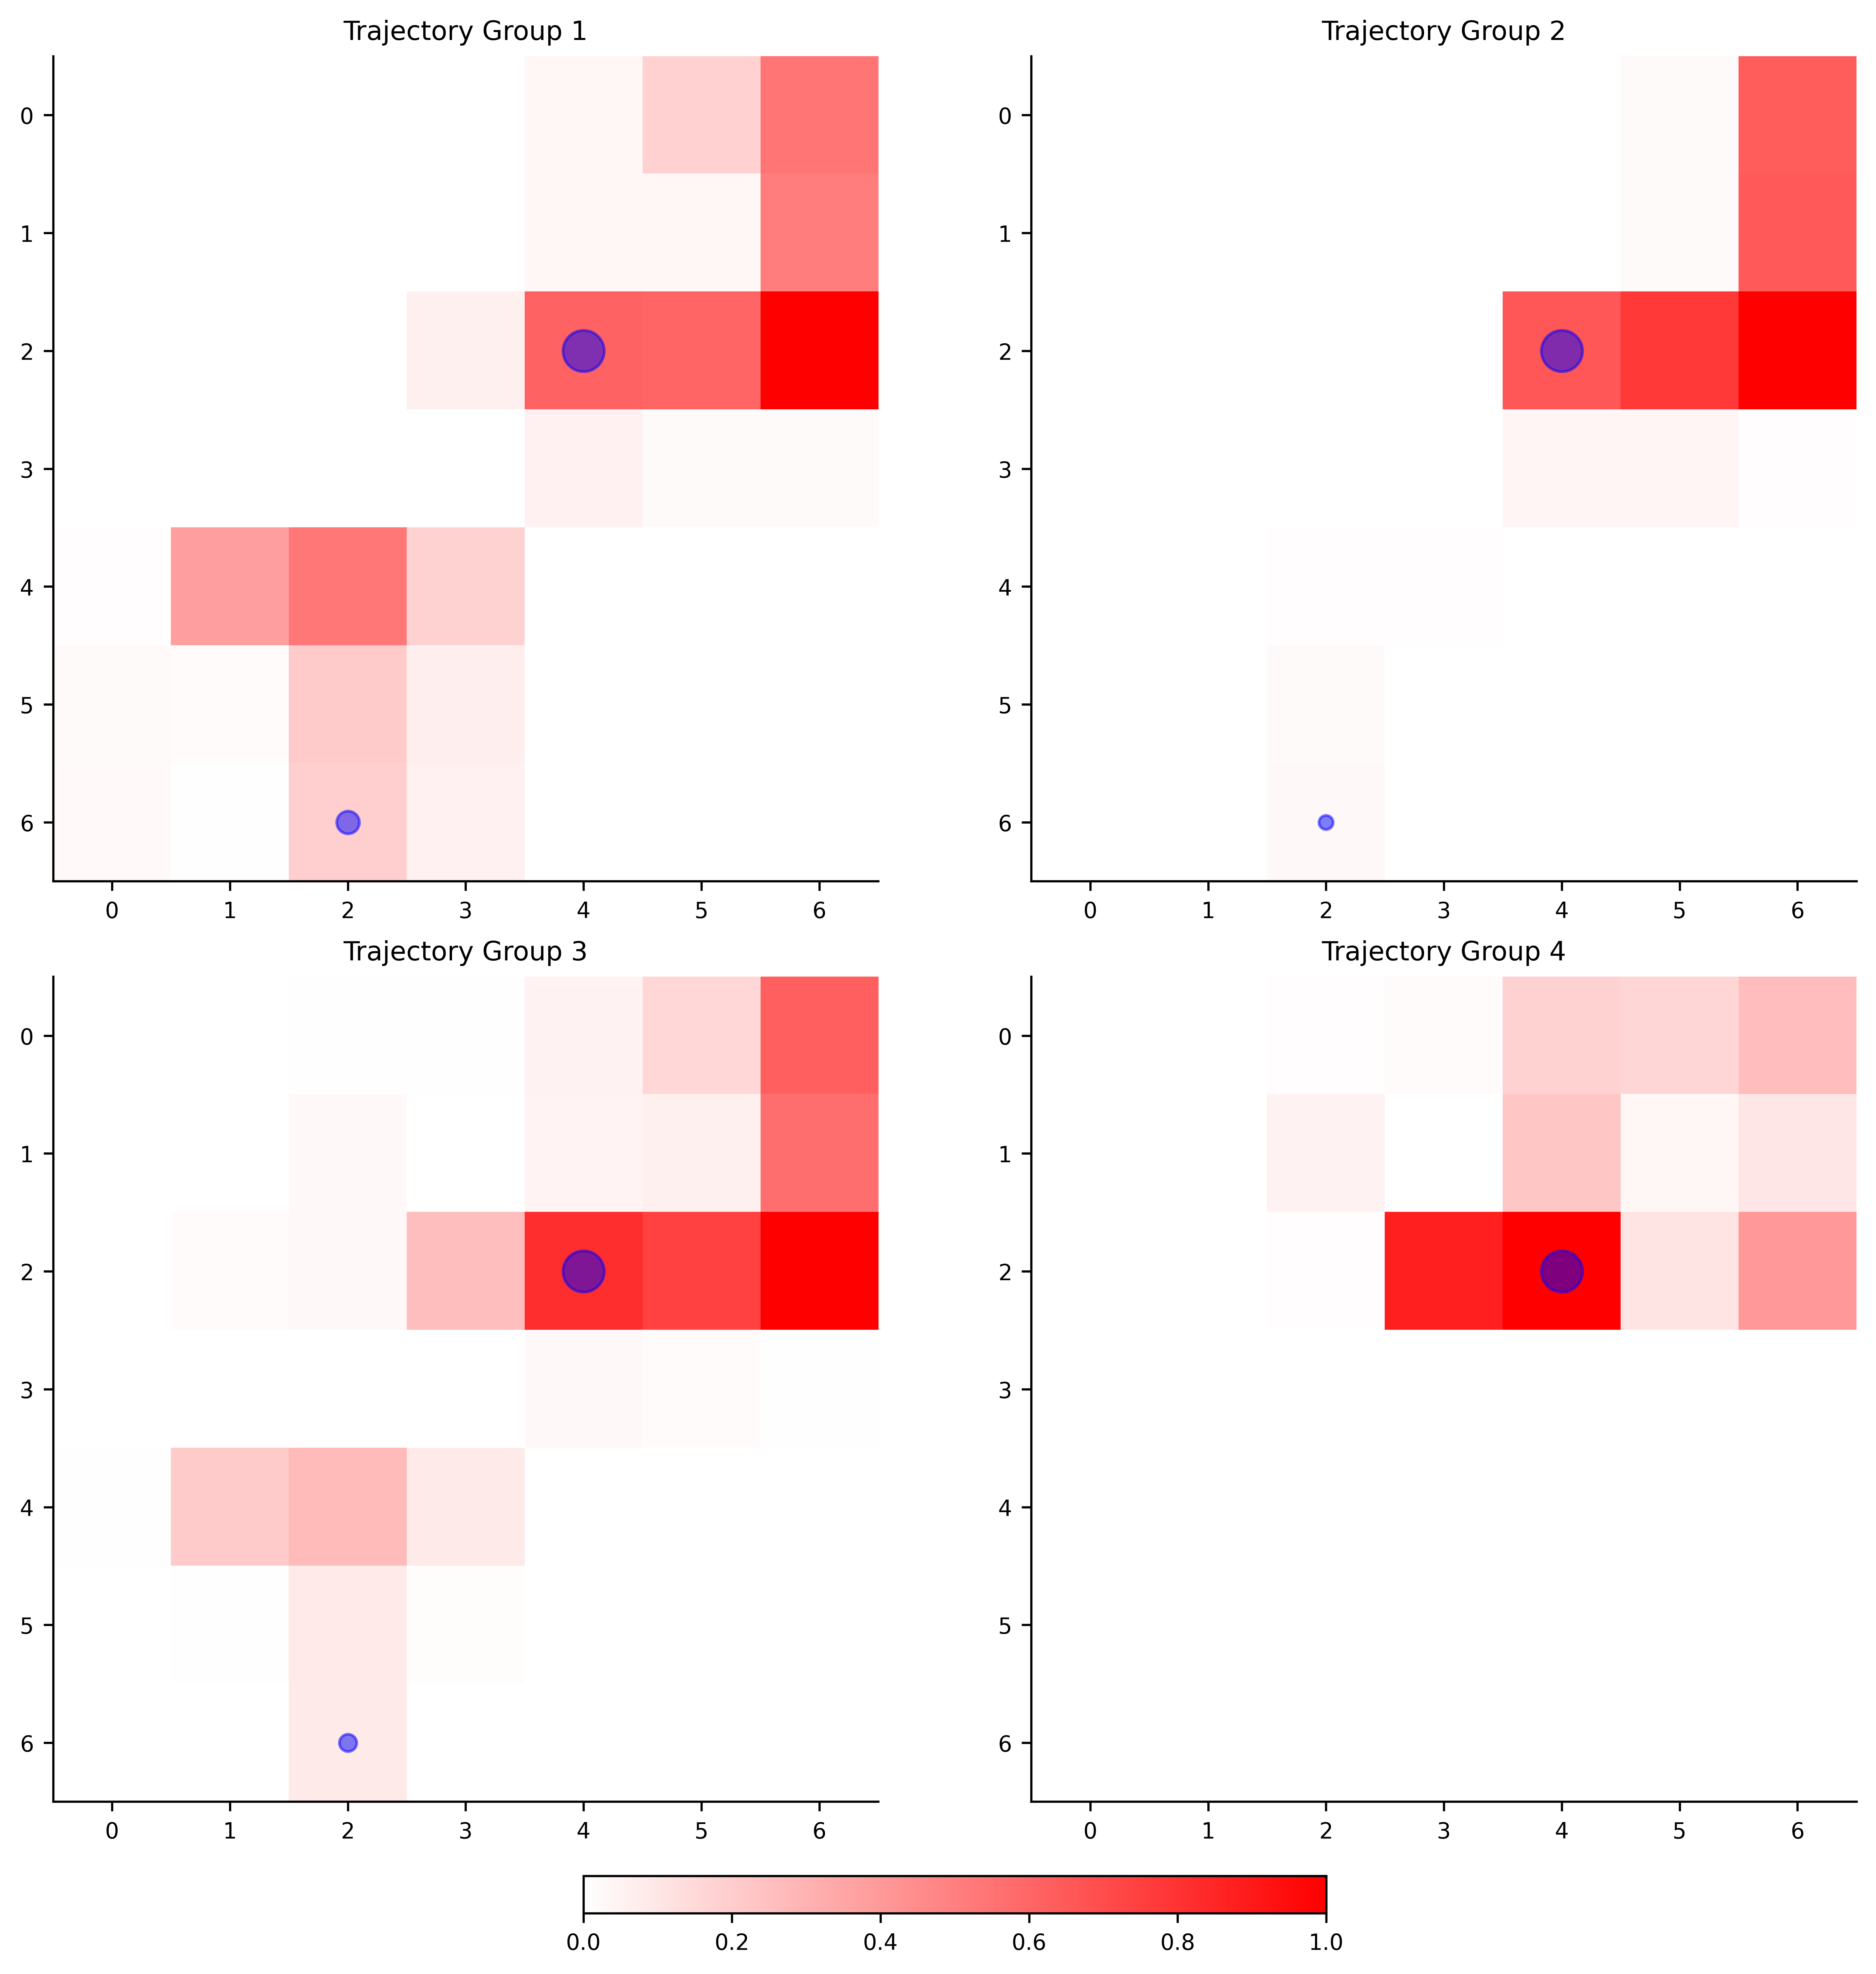

In [20]:
# Assuming 'clusters' is a list of clusters, each containing indices of trajectories in 'offline_data'
selected_clusters_indices = [0,1,2,3]  # Example selection of clusters for comparison

# Initialize a list to hold collected trajectories and starting points for each cluster
collected_clusters_trajectories = []
collected_clusters_starts = []

for cluster_index in selected_clusters_indices:
    collected_trajectories = []
    start_points = np.zeros(shape=env.dim)  # Assuming env.dim gives the dimension of the grid

    for trajectory_idx in clusters[cluster_index]:
        selected_trajectory = offline_data[trajectory_idx]
        collected_trajectories.append(selected_trajectory)
        
        # Assuming each trajectory[0] is the starting state and you can convert it to grid coordinates
        start_state = selected_trajectory[0][0]  # [0] for the first state-action-reward tuple, [0] for the state
        start_i, start_j = env.idx_to_coords(start_state)  # Convert start state to coordinates
        start_points[start_i, start_j] += 1  # Increment start point count

    collected_clusters_trajectories.append(collected_trajectories)
    collected_clusters_starts.append(start_points)

env.plot_traj_densities_with_starts(collected_clusters_trajectories, collected_clusters_starts)

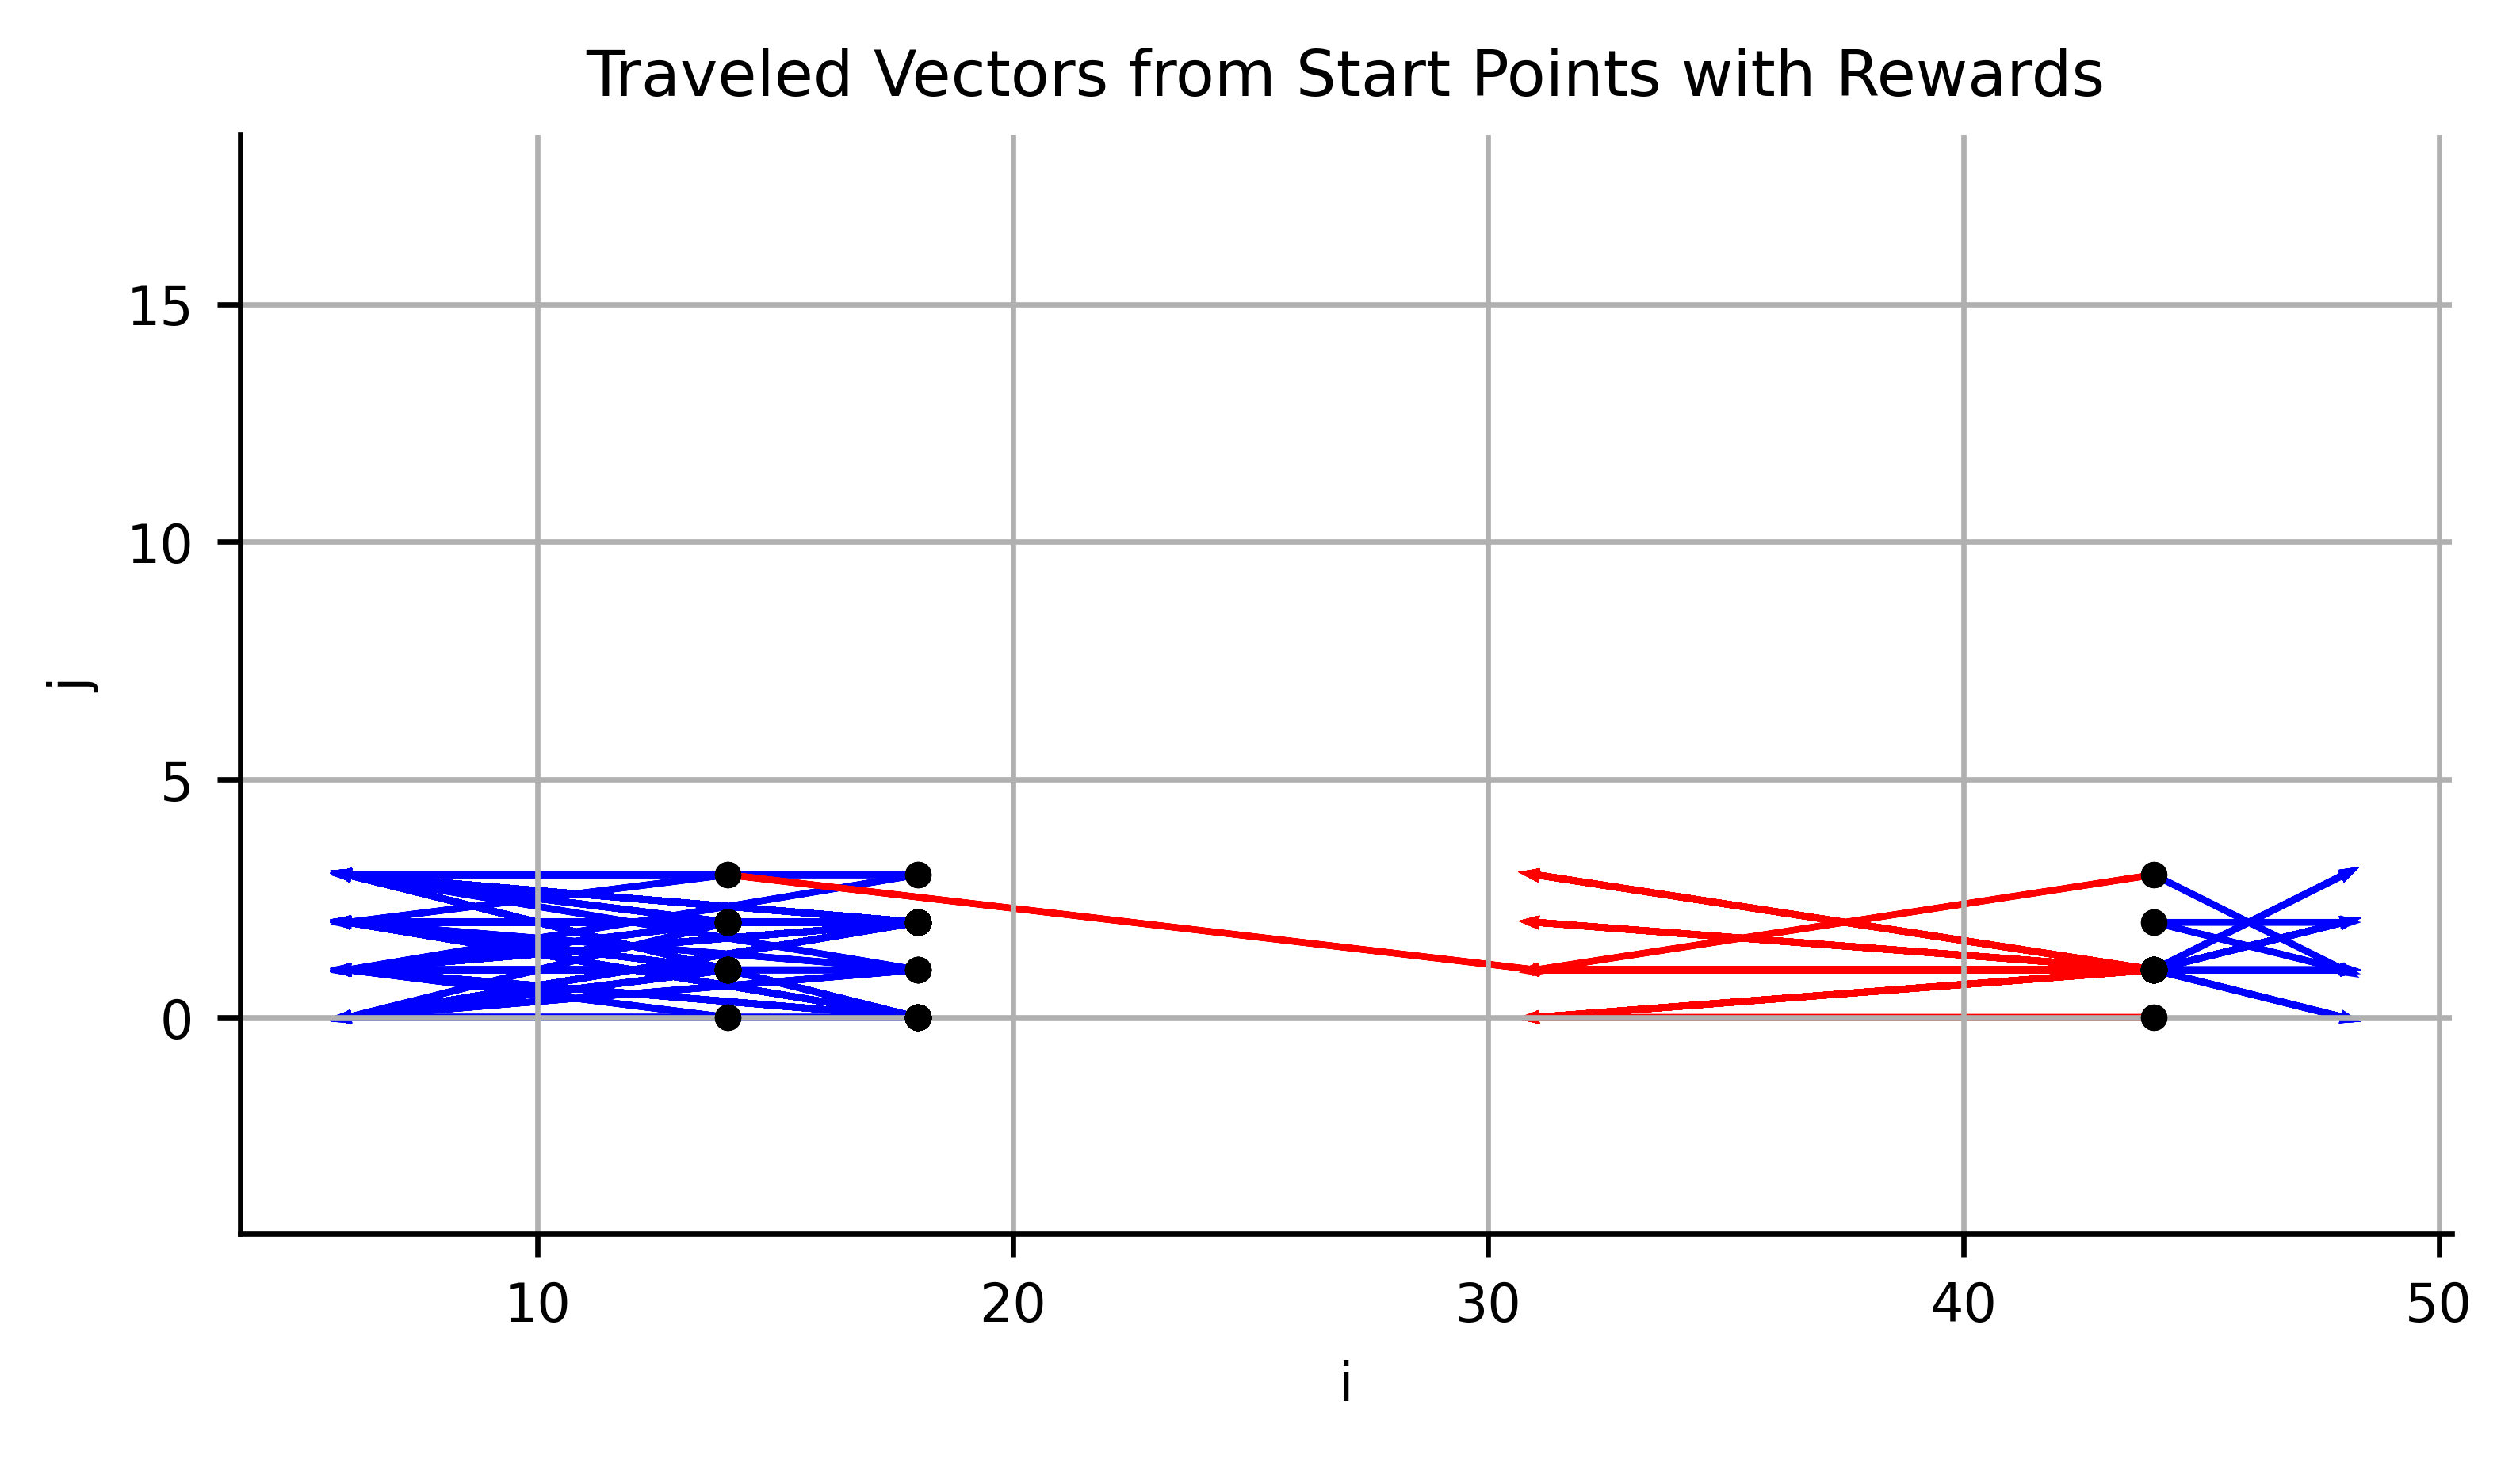

In [21]:
def plot_traveled_vectors_from_start_points(start_points, traveled_vectors, rewards):
    """
    Plots traveled vectors as directed lines from their start points, with start points represented as dots,
    and colors indicating the reward. Sets the y-axis limit to (-1, 6).
    
    Args:
    - start_points: A list of (start_i, start_j) tuples representing the start points.
    - traveled_vectors: A list of (delta_i, delta_j) tuples representing the vectors.
    - rewards: A list of rewards corresponding to each vector, where +1 is blue and -1 is red.
    """
    plt.figure(figsize=(6, 3))
    for start_point, vector, reward in zip(start_points, traveled_vectors, rewards):
        color = 'blue' if reward == 1 else 'red'  # Color based on reward
        start_i, start_j = start_point  # Start coordinates
        end_i, end_j = start_i + vector[0], start_j + vector[1]  # End coordinates based on vector
        # Plot the vector as an arrow
        plt.arrow(start_i, start_j, vector[0], vector[1], head_width=0.1, head_length=0.15, fc=color, ec=color)
        # Plot the start point as a dot
        plt.plot(start_i, start_j, 'o', color='black', markersize=3)
    
    # Setting axis labels and title
    plt.xlabel('i')
    plt.ylabel('j')
    plt.grid(True)
    plt.axis('equal')
    plt.title('Traveled Vectors from Start Points with Rewards')
    plt.ylim(-1, 15)
    plt.show()
    
def calculate_start_points_and_vectors(offline_data):
    """
    Calculates start points and traveled vectors from a list of trajectories.
    
    Args:
    - offline_data: A list of trajectories, each trajectory is a list of states,
      and each state is represented by coordinates (i, j).
    
    Returns:
    - start_points: A list of (i, j) tuples representing the start points of each trajectory.
    - traveled_vectors: A list of (delta_i, delta_j) tuples representing the traveled vector 
      from start to end of each trajectory.
    """
    start_points = []
    traveled_vectors = []

    for traj in offline_data:
        if not traj:  # Check if the trajectory is empty
            continue

        # Extract start and end points
        start_point = traj[0][:2]
        end_point = traj[-1][:2]

        # Calculate the traveled vector
        vector = (end_point[0] - start_point[0], end_point[1] - start_point[1])

        # Append to lists
        start_points.append(start_point)
        traveled_vectors.append(vector)

    return start_points, traveled_vectors

start_points, traveled_vectors = calculate_start_points_and_vectors(offline_data)
plot_traveled_vectors_from_start_points(start_points, traveled_vectors, rewards)

In [22]:
# for cluster_id, cluster in enumerate(clusters):
#     print('-'*10)
#     print('Cluster ID', cluster_id)
#     for traj_id in cluster:
#         env.plot_traj(offline_data[traj_id])    
#     print('-'*10)

In [23]:
traj_cluster_labels = np.zeros(len(traj_embeddings), dtype=int)

for cluster_id, cluster in enumerate(clusters):
    for traj_id in cluster:
        traj_cluster_labels[traj_id] = cluster_id


In [24]:
palette = sns.color_palette('husl', len(clusters) + 1)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8836443049112893, 0.5240073524369634, 0.19569304285113343),
 (0.710130687316902, 0.6046852192663268, 0.19426060163712158),
 (0.5432776721247529, 0.6540981095185215, 0.19324494273892204),
 (0.19592059105779686, 0.6981620017487838, 0.3452219818913641),
 (0.2067117296964458, 0.6829103404254792, 0.5829988925822328),
 (0.21420912437215422, 0.6714963557258681, 0.6986206664203177),
 (0.22537170008202412, 0.6531400148480775, 0.841007805313343),
 (0.5596943802099308, 0.5764402169887779, 0.9583930713150347),
 (0.8578978803740231, 0.44058452715322166, 0.957819659566579),
 (0.9628653850704806, 0.4025928454059796, 0.7779310354076443)]

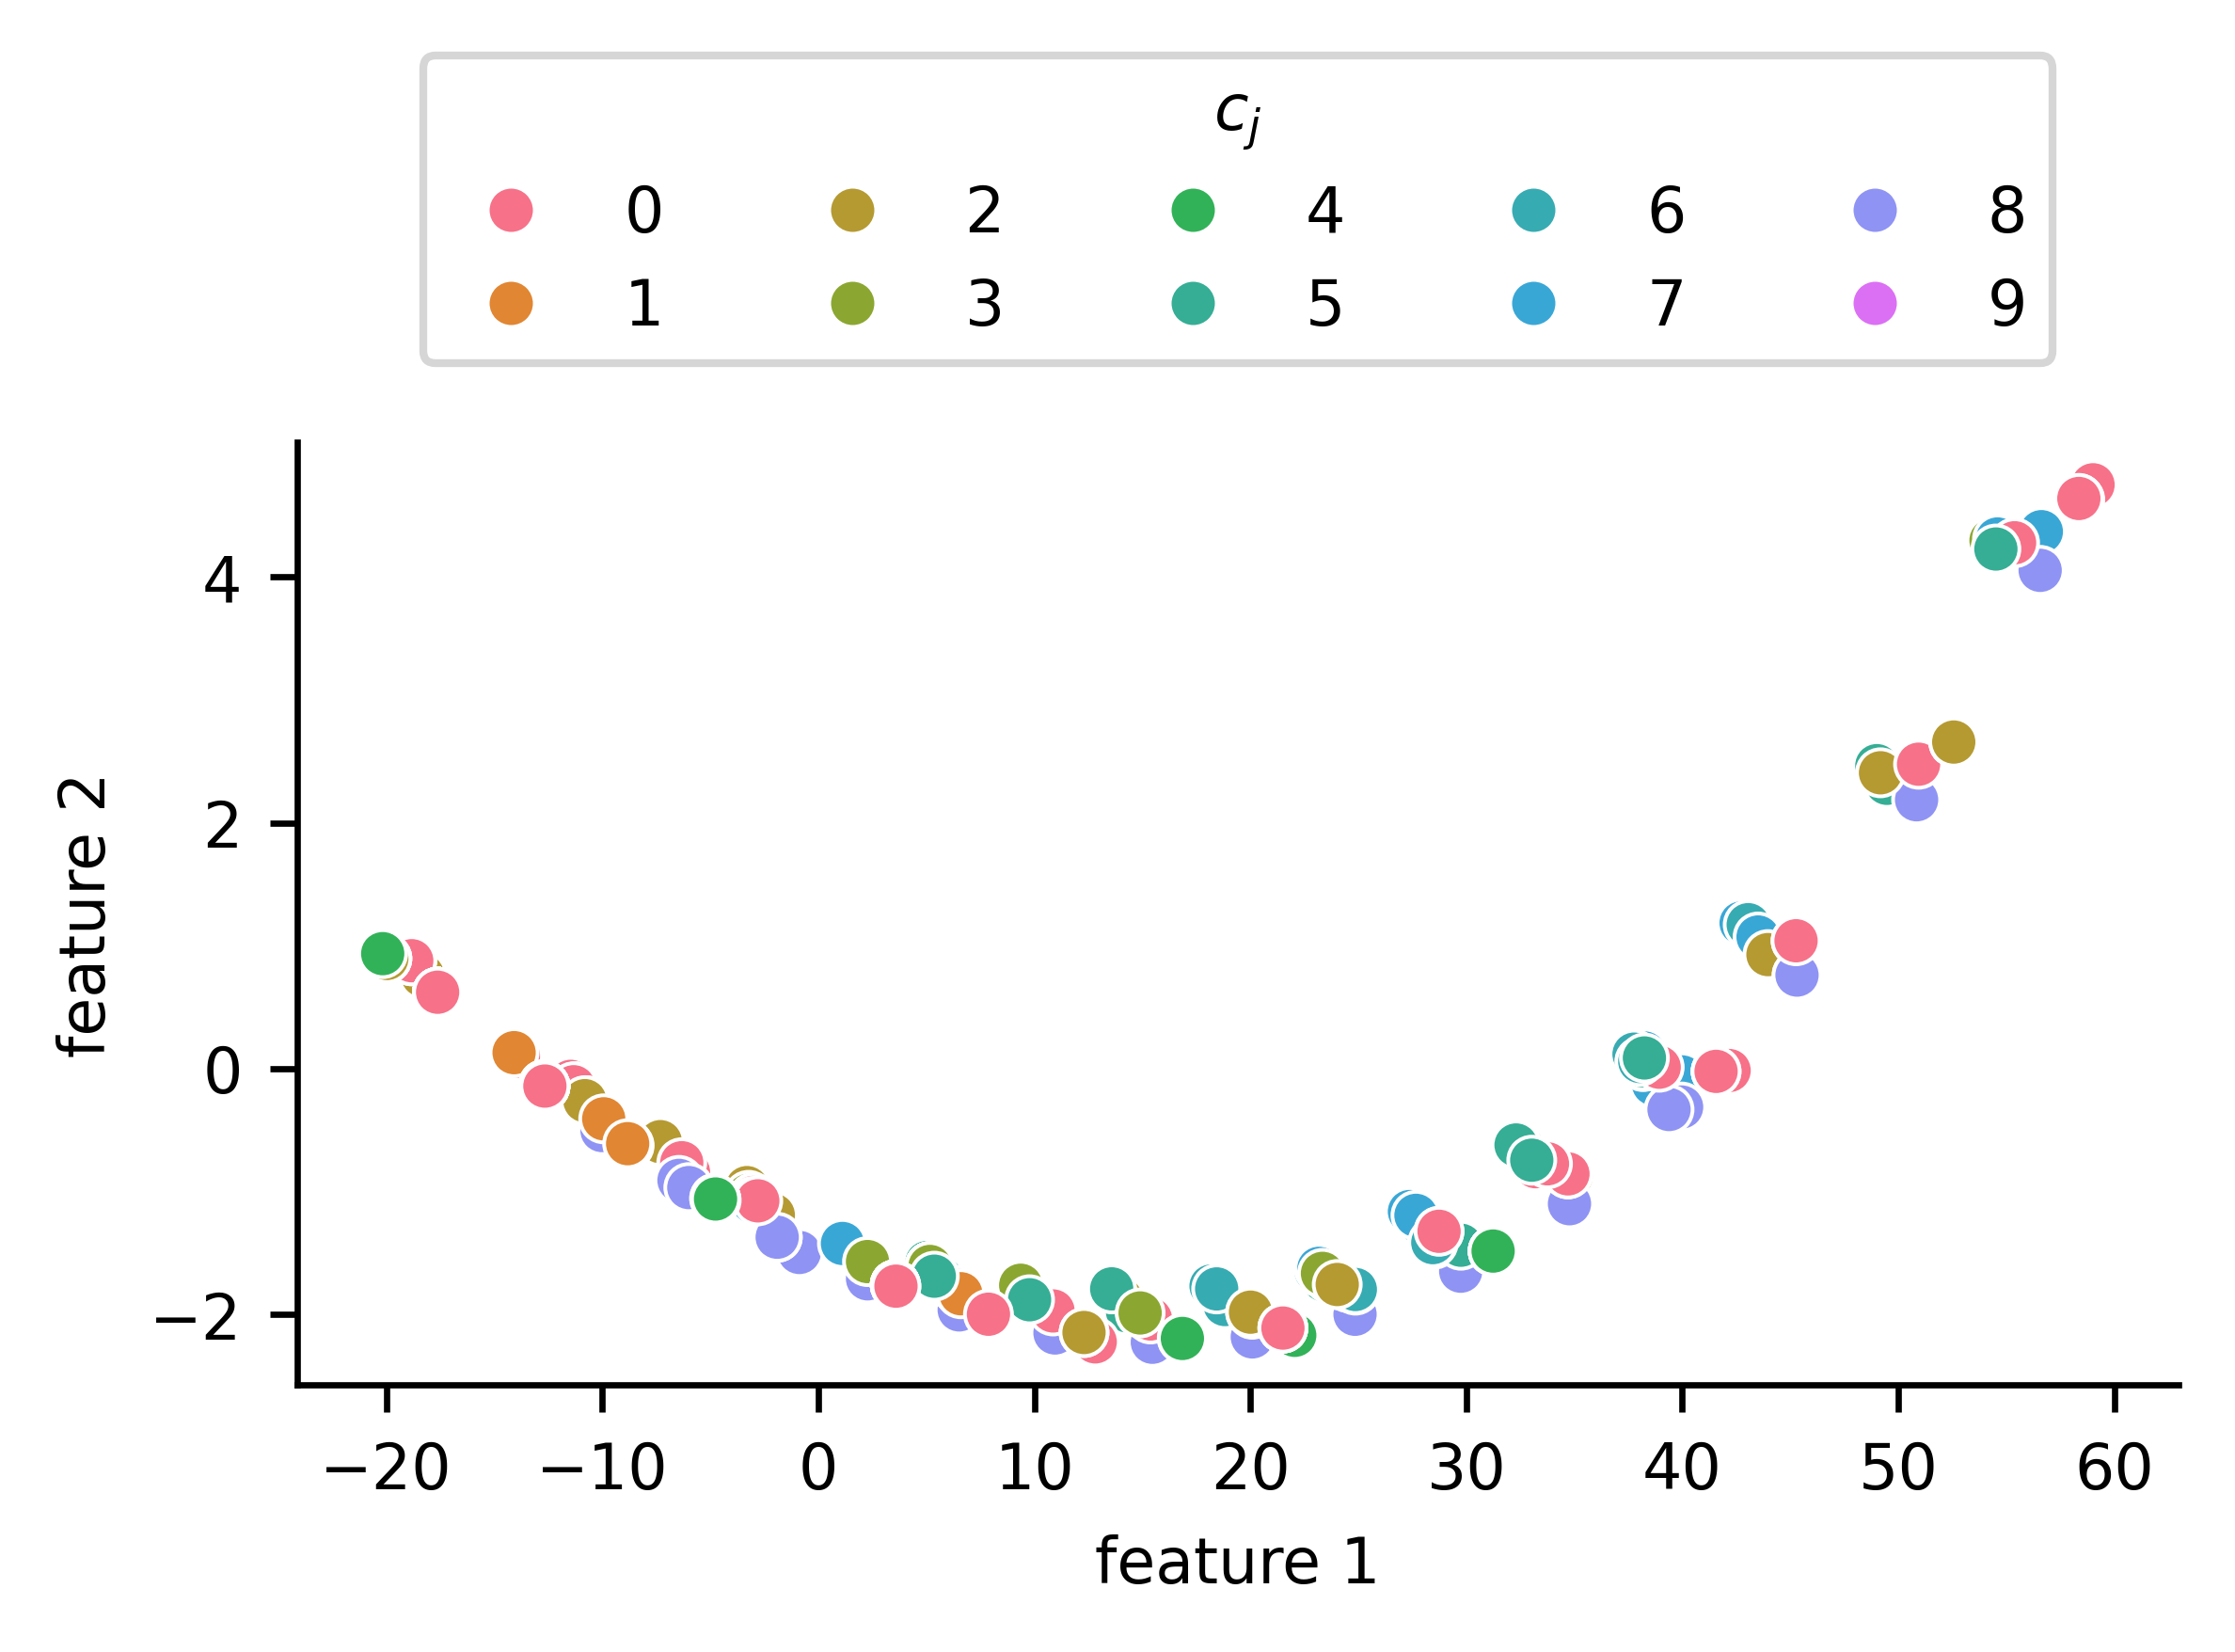

In [25]:
# cluster_data_embeds = [result_data_combinations[cid][1] for cid in result_data_combinations]
# cluster_data_embeds.pop(0)

pca_traj = PCA(n_components=2)
pca_traj_embeds = pca_traj.fit_transform(traj_embeddings)
plotting_data = {'feature 1': pca_traj_embeds[:, 0],
                 'feature 2': pca_traj_embeds[:, 1],
                 'cluster id': traj_cluster_labels}
df = pd.DataFrame(plotting_data)

plt.figure(figsize=(4,3))
data_ax = sns.scatterplot(x='feature 1',
                          y='feature 2',
                          hue='cluster id',
                          palette=palette[:len(clusters)],
                          data=df,
                          legend=True)
plt.legend(title = '$c_{j}$', loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5)
# plt.legend(title = '$c_{j}$', loc='center left', bbox_to_anchor=(1., 0.7), ncol=2)
# for cid, _ in enumerate(cluster_data_embeds):
#     data_ax.text(pca_data_embeds[:, 0][cid],
#                  pca_data_embeds[:, 1][cid],
#                  str(cid),
#                  horizontalalignment='left',
#                  size='medium',
#                  color='black',
#                  weight='semibold')
plt.tight_layout()
plt.savefig('./traj_clustering_grid.pdf')
plt.show()

## Encode sets of trajectories

In [26]:
def get_data_embedding(traj_embeddings):
#     return np.exp(np.abs(np.array(traj_embeddings).sum(axis=0)/100.))/np.sum(np.abs(np.exp(np.array(traj_embeddings).sum(axis=0)/100.)))
    return np.exp(np.array(traj_embeddings).sum(axis=0)/10.)/np.sum(np.exp(np.array(traj_embeddings).sum(axis=0)/10.))

data_embedding = get_data_embedding(traj_embeddings)

/tmp/ipykernel_238049/3510258333.py:3: RuntimeWarning: overflow encountered in exp
  return np.exp(np.array(traj_embeddings).sum(axis=0)/10.)/np.sum(np.exp(np.array(traj_embeddings).sum(axis=0)/10.))
/tmp/ipykernel_238049/3510258333.py:3: RuntimeWarning: invalid value encountered in divide
  return np.exp(np.array(traj_embeddings).sum(axis=0)/10.)/np.sum(np.exp(np.array(traj_embeddings).sum(axis=0)/10.))


### Train models on different cluster combinations

In [27]:
transition_model, reward_model = generate_model(env, offline_data)
values, action_values, policy = dp(env, transition_model, reward_model, gamma=0.95, threshold=1e-4)

In [28]:
result_data_combinations = {0:(action_values, data_embedding)}
cluster_embeddings = {}

for cluster_id, cluster in enumerate(clusters):
    temp_data = []
    temp_traj_embeds = []
    temp_cluster_traj_embeds = []
    for traj_id, traj in enumerate(offline_data):
        if traj_id not in cluster:
            temp_data.append(offline_data[traj_id])
            temp_traj_embeds.append(traj_embeddings[traj_id])
        else:
            temp_cluster_traj_embeds.append(traj_embeddings[traj_id])
            
    # Generate the data embedding
    data_embedding_new = get_data_embedding(temp_traj_embeds)
    
    # Generate cluster embedding
    cluster_embedding = get_data_embedding(temp_cluster_traj_embeds)
    
    # Train an agent on the new data
    transition_model_new, reward_model_new = generate_model(env, temp_data)
    values_new, action_values_new, policy_new = dp(env,
                                                   transition_model_new,
                                                   reward_model_new,
                                                   gamma=0.95,
                                                   threshold=1e-4)
    
    # Collect the data embedding and the trajectory
    result_data_combinations[cluster_id + 1] = (action_values_new, data_embedding_new)
    cluster_embeddings[cluster_id] = cluster_embedding

/tmp/ipykernel_238049/3510258333.py:3: RuntimeWarning: overflow encountered in exp
  return np.exp(np.array(traj_embeddings).sum(axis=0)/10.)/np.sum(np.exp(np.array(traj_embeddings).sum(axis=0)/10.))
/tmp/ipykernel_238049/3510258333.py:3: RuntimeWarning: invalid value encountered in divide
  return np.exp(np.array(traj_embeddings).sum(axis=0)/10.)/np.sum(np.exp(np.array(traj_embeddings).sum(axis=0)/10.))


### Generate attributions

In [29]:
attributions = []

for state in range(np.prod(env.dim)):
    
    if (state//env_width, state%env_width) in env.terminals:
        continue
        
    orig_state_action_values = action_values[state]
    orig_opt_state_actions = np.where(orig_state_action_values == np.max(orig_state_action_values))[0]

    distances = []
    new_actions = []
    for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items():
        new_state_action_values = action_values_new[state]
        new_opt_state_actions = np.where(new_state_action_values == np.max(new_state_action_values))[0]

        if list(new_opt_state_actions) != list(orig_opt_state_actions):
            w_d = wasserstein_distance(data_embedding, data_embedding_new)
        else:
            w_d = 1e9
        
        distances.append(w_d)
        new_actions.append(new_opt_state_actions)
    
    responsible_data_combination = np.argsort(distances)[0]
    
    if distances[responsible_data_combination] == 1e9 or distances[responsible_data_combination] == 0:
        continue
    
    print('-'*10)
    print(f'State - {state%env_width + 1, state//env_width + 1}')
    print(f'Distance - {distances[responsible_data_combination]}')
    print(f'Original Actions -{[action_dict[orig_action] for orig_action in orig_opt_state_actions]}')
    print(f'New Action - {[action_dict[new_action] for new_action in new_actions[responsible_data_combination]]}')

    print(f'Responsible data combination - data id {responsible_data_combination}')
    print(f'Responsible trajectory id {clusters[responsible_data_combination - 1]}')
    if len(clusters[responsible_data_combination - 1]):
        cid_list = list(range(len(clusters)))
        cid_list.pop(responsible_data_combination - 1)
        alternate_cid = np.random.choice(cid_list)
        attributions.append({
            'state' : (state%env_width + 1, state//env_width + 1),
            'orig_act': [action_dict[orig_action] for orig_action in orig_opt_state_actions],
            'new_act': [action_dict[new_action] for new_action in new_actions[responsible_data_combination]],
            'attributed_trajs':clusters[responsible_data_combination - 1],
            'random_baseline_trajs': list(np.random.randint(0, len(offline_data), 5)),
            'alternate_cluster_trajs': clusters[alternate_cid - 1],
            'responsible_cluster': responsible_data_combination - 1
        })
#         for traj in clusters[responsible_data_combination - 1]:
#             env.plot_traj(offline_data[traj])
    print('-'*10)

In [30]:
attributions

[]

In [31]:
results_save_dir = './gridworld_results/grid_7by7/'
if not os.path.exists(results_save_dir):
    os.makedirs(results_save_dir)


# for traj_id, traj in enumerate(offline_data):
#     env.plot_traj(traj, path=os.path.join(results_save_dir, 'traj_' + str(traj_id) + '.png'))


In [32]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [33]:
# Data to save
data_to_be_saved = [
    {
        'attributions' : attributions,
    }
]

dumped = json.dumps(data_to_be_saved, cls=NumpyEncoder)

with open(os.path.join(results_save_dir, 'attribution_results.json'), 'w') as f:
    json.dump(dumped, f)

In [34]:
attributions

[]

## Initial State Value Estimates

In [35]:
for data_combination_id in result_data_combinations:
    print(result_data_combinations[data_combination_id][0].max(axis=1).mean())

0.3792304780897112
0.37817033611750694
0.37830130295684505
0.3793555778669851
0.3795143264036173
0.3737848969842207
0.38059022935959824
0.380206800250224
0.380149766359784
0.2406889004911631
0.3788059937039604


## Average delta q

In [36]:
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    print(np.sum(np.abs(action_values_new - result_data_combinations[0][0]))/(env_width*env_height))

0.0
0.04629857756002323
0.0037167268823135604
0.03552940869962968
0.0031687311317709966
0.02045072917300145
0.027897686425256484
0.0032752357619285563
0.022393888492952933
0.3410836391389172
0.007142002875220587


## Compare the actions

In [37]:
action_comparison = {}
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    action_comparison[data_combination_id] = 0
    for i in range(env_width*env_height):
            orig_actions = np.where(result_data_combinations[0][0][i] == np.max(result_data_combinations[0][0][i]))[0]
            alternate_actions = np.where(result_data_combinations[data_combination_id][0][i] == np.max(result_data_combinations[data_combination_id][0][i]))[0]
            
            if list(orig_actions) == list(alternate_actions):
                action_comparison[data_combination_id] += 1 
#             alternate_actions = 
#     print(np.sum(np.argmax(action_values_new, axis=1) != np.argmax(result_data_combinations[0][0], axis=1))/(env_width*env_height))

In [38]:
np.array(list(action_comparison.values()))/(env_width*env_height)

array([1.        , 0.87755102, 0.79591837, 0.7755102 , 0.7755102 ,
       0.87755102, 0.91836735, 0.93877551, 0.95918367, 0.59183673,
       0.81632653])

## Data distances

In [39]:
data_distances = np.zeros(len(result_data_combinations))
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    data_distances[data_combination_id] = wasserstein_distance(data_embedding, data_embedding_new)

In [40]:
with np.printoptions(precision=5, suppress=True):
    print((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))

[nan nan nan nan nan nan nan nan nan nan nan]


## Cluster Attribution Frequency

In [41]:
cluster_attr_freq = np.zeros(len(clusters))

In [42]:
for attribution in attributions:
    cluster_attr_freq[attribution['responsible_cluster']] += 1 

In [43]:
cluster_attr_freq/cluster_attr_freq.sum()

/tmp/ipykernel_238049/1265153773.py:1: RuntimeWarning: invalid value encountered in divide
  cluster_attr_freq/cluster_attr_freq.sum()


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])